In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm

In [2]:
root = '/projects/chimera/zucksliu/AI-READI-2.0/dataset/'
octa_dir = root + 'retinal_octa/'
octa_manifest_tsv = octa_dir + 'manifest.tsv'

full_manifest = pd.read_csv(octa_manifest_tsv, sep='\t')

if 'participant_id' not in full_manifest.columns:
    raise ValueError("The manifest must contain a 'participant_id' column for splitting.")

unique_ids = full_manifest['participant_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_ids)

split_idx = int(0.9 * len(unique_ids))
selected_ids = unique_ids[split_idx:]
manifest = full_manifest[full_manifest['participant_id'].isin(selected_ids)].reset_index(drop=True)

print(selected_ids)

[1129 7402 4148 7186 7392 1065 7159 1015 1158 1041 4119 1382 1189 7110
 1218 7271 7138 1053 7227 1340 7092 7059 7064 1298 7037 1253 7066 4088
 4082 1272 7162 7211 1271 7384 1203 1163 4183 7069 4025 7038 4103 7168
 7118 1106 4193 4009 1002 7377 7405 4189 7281 1081 1207 1035 7292 7122
 4136 4054 4081 7398 1369 1092 1342 7246 4192 1348 7123 7368 1243 1014
 1318 4229 4006 1168 7188 1021 4277 7179 4190 7386 7017 7307 1191 7326
 7034 4138 4101 7204 7090 1254 1022 4086 1278 7305 4004 7152 1346 7116
 1131 7220 1088 1333 4093 1122 7395 7209]


In [3]:
class_names = ['Background', 'Capillary', 'Artery', 'Vein', 'FAZ']
probabilities_by_class = {cls: [] for cls in class_names}
grouped = manifest.groupby('participant_id')
for p_id in tqdm(selected_ids, desc='Processing participants'):
    group_df = grouped.get_group(p_id)
    for idx, row in group_df.iterrows():
        label_dir = os.path.join(octa_dir, 'OneNorm_test_set', f"{p_id}",
                                            f"{row['manufacturers_model_name']}_{row['laterality']}_{row['anatomic_region']}")
        # label_dir = os.path.join(octa_dir, 'GAN_groupnorm_test_set', f"{p_id}",
                                            # f"{row['manufacturers_model_name']}_{row['laterality']}_{row['anatomic_region']}")
        label_path = os.path.join(label_dir, "CAVF_softmax.npy")
        if os.path.exists(label_path):
            data_label = np.load(label_path)
            predicted = np.argmax(data_label, axis=0)
            for i, cls in enumerate(class_names):
                mask = (predicted == i)
                class_probs = data_label[i][mask]
                probabilities_by_class[cls].extend(class_probs.tolist())
        else:
            raise FileNotFoundError(f"Label file not found: {label_path}")

Processing participants: 100%|██████████| 106/106 [14:21<00:00,  8.12s/it]


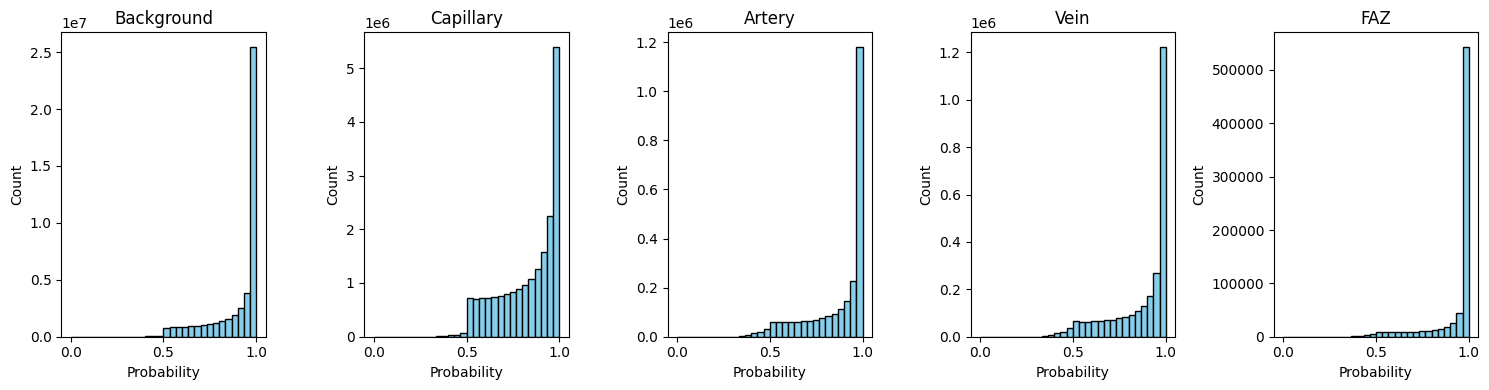

In [4]:
plt.figure(figsize=(15, 4))
for i, cls in enumerate(class_names):
    plt.subplot(1, 5, i+1)
    probs = np.array(probabilities_by_class[cls])
    plt.hist(probs, bins=30, range=(0, 1), color='skyblue', edgecolor='black')
    plt.title(cls)
    plt.xlabel('Probability')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

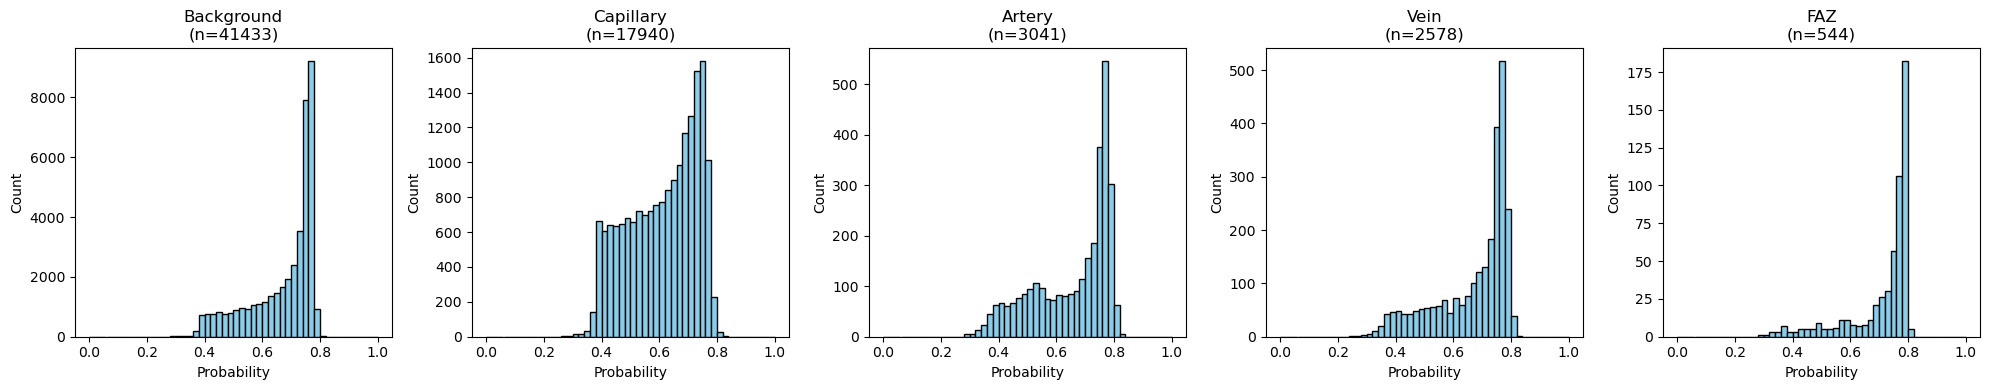

In [12]:
participant_id = "1129"
manufacturer = "Cirrus"
laterality = "L"
anatomic_region = "Macula, 6 x 6"

label_dir = os.path.join(octa_dir, 'GAN_groupnorm_test_set', participant_id,
                         f"{manufacturer}_{laterality}_{anatomic_region}")
label_path = os.path.join(label_dir, "CAVF_softmax.npy")

data_label = np.load(label_path)

predicted = np.argmax(data_label, axis=0)

class_names = ['Background', 'Capillary', 'Artery', 'Vein', 'FAZ']

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, cls in enumerate(class_names):
    cls_mask = (predicted == i)
    probs = data_label[i, :, :][cls_mask]

    axs[i].hist(probs, bins=50, range=(0, 1), color='skyblue', edgecolor='black')
    axs[i].set_title(f'{cls}\n(n={probs.size})')
    axs[i].set_xlabel('Probability')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

256


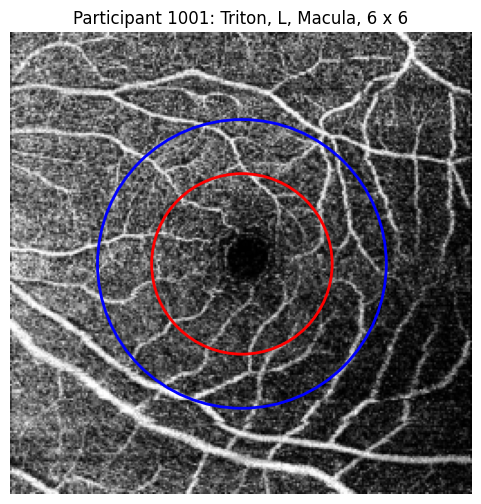

In [8]:
import os.path as osp
import pydicom
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cv2

participant_id = "1001"
manufacturer = "Triton"
laterality = "L"
anatomic_region = "Macula, 6 x 6"

root = '/projects/chimera/zucksliu/AI-READI-2.0/dataset/'
manifest_path = osp.join(root, "retinal_octa", "manifest.tsv")

# Read the manifest. Assuming it is tab-separated.
manifest = pd.read_csv(manifest_path, sep='\t')

# (Optional) Strip whitespace from relevant columns.
manifest['participant_id'] = manifest['participant_id'].astype(str).str.strip()
manifest['manufacturers_model_name'] = manifest['manufacturers_model_name'].astype(str).str.strip()
manifest['laterality'] = manifest['laterality'].astype(str).str.strip()
manifest['anatomic_region'] = manifest['anatomic_region'].astype(str).str.strip()

# Filter the manifest for the desired patient.
selected = manifest[
    (manifest['participant_id'] == participant_id) &
    (manifest['manufacturers_model_name'] == manufacturer) &
    (manifest['laterality'] == laterality) &
    (manifest['anatomic_region'] == anatomic_region)
]

if selected.empty:
    print("No matching patient found.")
else:
    # For demonstration, use the first matching row.
    row = selected.iloc[0]
    # Assume the DICOM file for the OCT image is stored in a column named 'associated_structural_oct_file_path'
    oct_fp = root + row['associated_enface_1_file_path']
    if not osp.exists(oct_fp):
        raise FileNotFoundError(f"File not found: {oct_fp}")

    # Read the DICOM file.
    ds = pydicom.dcmread(oct_fp)
    img = ds.pixel_array  # This is usually a 2D array

    print(len(np.unique(img)))

    img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR)

    # Get new image dimensions and center coordinates
    h, w = img_resized.shape
    center_x, center_y = w // 2, h // 2

    # Define circle radii
    radius_50 = 50
    radius_80 = 80

    # Plot the resized image
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_resized, cmap='gray')

    # Draw two circles as outlines
    circle_50 = Circle((center_x, center_y), radius_50, color='r', fill=False, linewidth=2)
    circle_80 = Circle((center_x, center_y), radius_80, color='b', fill=False, linewidth=2)

    # Add circles to the plot
    ax.add_patch(circle_50)
    ax.add_patch(circle_80)

    # Set title and remove axis
    ax.set_title(f"Participant {participant_id}: {manufacturer}, {laterality}, {anatomic_region}")
    ax.axis("off")

    # Show the image
    plt.show()

In [9]:
cols = ['participant_id', 'manufacturers_model_name', 'laterality', 'anatomic_region']
for col in cols:
    manifest[col] = manifest[col].astype(str).str.strip()

# Group by the four columns.
grouped = manifest.groupby(cols)

# Filter groups that have more than one row.
duplicates = grouped.filter(lambda x: len(x) > 1)

# Print the resulting DataFrame.
print("Rows with duplicate values across the specified columns:")
print(len(duplicates))
print(duplicates[cols])

duplicates['human_chosen'] = None

# Save only the specified columns along with the new "human_chosen" column to a CSV file.
output_csv_path = "duplicates.csv"
duplicates[cols + ['human_chosen']].to_csv(output_csv_path, index=False)

print(f"CSV file saved to {output_csv_path}")

Rows with duplicate values across the specified columns:
1107
      participant_id manufacturers_model_name laterality    anatomic_region
8               1001                   Cirrus          L      Macula, 6 x 6
9               1001                   Cirrus          L      Macula, 6 x 6
128             1015                 Maestro2          R      Macula, 6 x 6
129             1015                 Maestro2          R      Macula, 6 x 6
130             1015                   Triton          L    Macula, 12 x 12
...              ...                      ...        ...                ...
10323           7392                   Cirrus          L  Optic Disc, 6 x 6
10357           7396                   Cirrus          L  Optic Disc, 6 x 6
10358           7396                   Cirrus          L  Optic Disc, 6 x 6
10489           7411                   Triton          R    Macula, 12 x 12
10490           7411                   Triton          R    Macula, 12 x 12

[1107 rows x 4 columns]
C

In [9]:
from PIL import Image
output_qc_dir = "/m-ent1/ent1/zucksliu/SFDA-CBMT_results/duplicate_image_qc"

counters = {}

for index, row in duplicates.iterrows():
    participant_id = row['participant_id']

    # Compute a matching key from the four columns.
    # If 'key' exists in the row, use it; otherwise, compute it.
    if 'key' in row:
        key = row['key']
    else:
        key = (row['participant_id'] + '_' +
               row['manufacturers_model_name'] + '_' +
               row['laterality'] + '_' +
               row['anatomic_region'])

    # Create a grouping key as a tuple.
    group_key = (participant_id, key)

    # Initialize or get the current counter for this group.
    if group_key not in counters:
        counters[group_key] = 0
    current_counter = counters[group_key]

    # Create the filename prefix using the current counter.
    prefix_name = f"{current_counter}_"

    # Increment the counter for this group.
    counters[group_key] += 1

    # Build the source file path.
    enface_rel_path = row['associated_enface_1_file_path'].strip()
    src_path = root + enface_rel_path

    # Check if the source file exists.
    if not osp.exists(src_path):
        print(f"Warning: Source file not found for participant {participant_id}: {src_path}")
        continue

    # Create the destination directory for this participant.
    dest_folder = osp.join(output_qc_dir, participant_id)
    os.makedirs(dest_folder, exist_ok=True)

    # Build the destination file name.
    base = osp.splitext(osp.basename(src_path))[0]
    dest_path = osp.join(dest_folder, prefix_name + base + ".png")

    try:
        # Read the DICOM file.
        ds = pydicom.dcmread(src_path)
        pixel_array = ds.pixel_array
        # Convert the NumPy array to a PIL Image.
        pil_img = Image.fromarray(pixel_array)
        # Save the image as PNG.
        pil_img.save(dest_path, "PNG")
        print(f"Saved {src_path} as {dest_path}")
    except Exception as e:
        print(f"Error processing {src_path}: {e}")

Saved /projects/chimera/zucksliu/AI-READI-2.0/dataset//retinal_octa/enface/zeiss_cirrus/1001/1001_cirrus_macula_6x6_octa_enface_l_1.2.276.0.75.2.2.42.215507196755019.20230727173746087.5564373001.dcm as /m-ent1/ent1/zucksliu/SFDA-CBMT_results/duplicate_image_qc/1001/0_1001_cirrus_macula_6x6_octa_enface_l_1.2.276.0.75.2.2.42.215507196755019.20230727173746087.5564373001.png
Saved /projects/chimera/zucksliu/AI-READI-2.0/dataset//retinal_octa/enface/zeiss_cirrus/1001/1001_cirrus_macula_6x6_octa_enface_l_1.2.276.0.75.2.2.42.215507196755019.20230727173859402.5564946031.dcm as /m-ent1/ent1/zucksliu/SFDA-CBMT_results/duplicate_image_qc/1001/1_1001_cirrus_macula_6x6_octa_enface_l_1.2.276.0.75.2.2.42.215507196755019.20230727173859402.5564946031.png
Saved /projects/chimera/zucksliu/AI-READI-2.0/dataset//retinal_octa/enface/topcon_maestro2/1015/1015_maestro2_macula_6x6_enface_r_2.16.840.1.114517.10.5.1.4.907063120230821141153.6.3.dcm as /m-ent1/ent1/zucksliu/SFDA-CBMT_results/duplicate_image_qc/101

In [4]:
import os.path as osp

filter_path = '/data/zucksliu/ahonjaya_tempura_migrated/ahonjaya/logs/AI-READI-Results/OCTA/Averaged_Results/'

participant_folders = [d for d in os.listdir(filter_path) if osp.isdir(osp.join(filter_path, d))]
print("Participant folders from filter_path:")
print(participant_folders)

root = '/projects/chimera/zucksliu/AI-READI-2.0/dataset/'
manifest_path = osp.join(root, "retinal_octa", "manifest.tsv")

# Read the manifest. Assuming it is tab-separated.
manifest = pd.read_csv(manifest_path, sep='\t')

# Clean up the participant_id column.
manifest['participant_id'] = manifest['participant_id'].astype(str).str.strip()

# Get the unique participant IDs from the manifest.
unique_participant_ids = manifest['participant_id'].unique().tolist()
print("\nUnique participant IDs from the manifest:")
print(unique_participant_ids)

# Compare the two lists.
common_ids = set(participant_folders) & set(unique_participant_ids)
only_in_manifest = set(unique_participant_ids) - set(participant_folders)
only_in_folder = set(participant_folders) - set(unique_participant_ids)

print("\nCommon IDs (in both):")
print(common_ids)
print("\nIDs only in the manifest:")
print(only_in_manifest)
print("\nIDs only in the filter folder:")
print(only_in_folder)

Participant folders from filter_path:
['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '1110', '1111', '1112', '1113', '1114', '1115', '1116', '1117', '1118', '1119', '1120', '

In [19]:
#!/usr/bin/env python
import os
import os.path as osp
import numpy as np
from tqdm import tqdm

# Base directory
filter_path = '/data/zucksliu/ahonjaya_tempura_migrated/ahonjaya/logs/AI-READI-Results/OCTA'

# The four top-level folders we need to use:
top_folders = ['Averaged_Results', 'GAN_groupnorm', 'NoNorm', 'OneNorm']

# Use one of the folders (here, Averaged_Results) as a reference to list patient IDs.
reference_folder = osp.join(filter_path, top_folders[0])
patient_ids = [d for d in os.listdir(reference_folder) if osp.isdir(osp.join(reference_folder, d))]
print(f"Found {len(patient_ids)} patients.")

def normalize_key(key):
    """
    Remove any occurrence of '3D' from the key so that
    "Cirrus_L_Macula, 6 x 6/800/3D/CAVF_softmax.npy" becomes
    "Cirrus_L_Macula, 6 x 6/800/CAVF_softmax.npy".
    """
    parts = key.split(os.sep)
    parts = [p for p in parts if p != "3D"]
    return os.sep.join(parts)

# We'll store the average image per file (for each top-level folder) in a dictionary.
# Each averaged image will be a 5-channel array (shape: [5, H, W]).
folder_avg_images = {}

# Process each top-level folder separately.
for folder in top_folders:
    print(f"\nProcessing folder: {folder}")
    avg_images = {}   # key: relative file path (from reference), value: accumulated sum array ([5, H, W])
    counts = {}       # key: relative file path, value: count of images for that file
    folder_path = osp.join(filter_path, folder)

    # Loop over patients (each patient is a subfolder under folder_path)
    for patient in tqdm(patient_ids, desc="Processing patients"):
        patient_path = osp.join(folder_path, patient)
        if not osp.isdir(patient_path):
            continue
        # Walk through the patient folder recursively.
        for dirpath, dirnames, filenames in os.walk(patient_path):
            for filename in filenames:
                if filename.endswith('.npy'):
                    full_path = osp.join(dirpath, filename)
                    # Compute the relative path with respect to the patient folder.
                    rel_path = osp.relpath(full_path, patient_path)
                    # Only process files that are in a folder named "800"
                    if "800" not in rel_path.split(os.sep):
                        continue
                    # Skip any file that has "2D" in its parts.
                    if "2D" in rel_path.split(os.sep):
                        continue
                    # (Optional) Skip any unwanted file by name.
                    if "AVA_softmax.npy" in rel_path:
                        continue

                    # For the "OneNorm" and "NoNorm" folders, modify the file path.
                    # We want to ensure that immediately after "800" there is "3D".
                    if folder in ["OneNorm", "NoNorm"]:
                        parts = rel_path.split(os.sep)
                        if "800" in parts:
                            idx = parts.index("800")
                            # If there is no element immediately after "800" or it's not "3D", insert "3D"
                            if idx + 1 >= len(parts) or parts[idx + 1] != "3D":
                                parts.insert(idx + 1, "3D")
                        rel_path_mod = os.sep.join(parts)
                        file_path = osp.join(filter_path, folder, patient, rel_path_mod)
                        # Use the original relative path (without the inserted "3D") as the key.
                        key = rel_path
                    else:
                        file_path = osp.join(filter_path, folder, patient, rel_path)
                        key = rel_path

                    try:
                        arr = np.load(file_path)  # expected shape: [5, H, W]
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")
                        continue

                    # Use the entire 5-channel array (do not reduce it).
                    prob_arr = arr.astype(np.float64)  # shape: [5, H, W]
                    # Accumulate the array and count using the common key.
                    if key not in avg_images:
                        avg_images[key] = prob_arr
                        counts[key] = 1
                    else:
                        avg_images[key] += prob_arr
                        counts[key] += 1
    # Compute the average array for each key in this folder.
    for key in avg_images:
        avg_images[key] /= counts[key]
    # For "NoNorm" and "OneNorm", normalize the keys by removing any "3D" so that they match the reference.
    if folder in ["NoNorm", "OneNorm"]:
        normalized = {}
        for k, v in avg_images.items():
            normalized_key = normalize_key(k)
            normalized[normalized_key] = v
        avg_images = normalized
    folder_avg_images[folder] = avg_images
    print(f"Folder {folder}: computed average images for {len(avg_images)} relative file(s).")

# Now, for each relative file (using keys from the reference folder), gather the average images from all top-level folders and compute per-class stats.
# We'll store the final stats as a dictionary:
#   final_stats[key] = a numpy array of shape [5, 2], where for each class c:
#      final_stats[key][c,0] = mean over pixels (averaged over the 4 model-average images)
#      final_stats[key][c,1] = std over pixels (computed across the 4 model-average images)
final_stats = {}

for key in folder_avg_images[top_folders[0]].keys():
    # Check that this key exists in every top-level folder.
    avg_list = []
    valid = True
    for folder in top_folders:
        if key in folder_avg_images[folder]:
            avg_list.append(folder_avg_images[folder][key])
        else:
            print(f"Relative file {key} not found in folder {folder}. Skipping.")
            valid = False
            break
    if not valid:
        continue
    # Stack the average arrays: shape becomes [4, 5, H, W]
    stacked = np.stack(avg_list, axis=0)
    stats = np.zeros((5, 2), dtype=np.float64)  # For 5 classes, two statistics: mean and std.
    # For each class, compute the mean and std over the 4 model-average images, averaged over all pixels.
    for c in range(5):
        class_data = stacked[:, c, :, :]  # shape: [4, H, W]
        mean_c = np.mean(class_data)  # mean over models and pixels
        std_c = np.std(class_data)    # std over models and pixels
        stats[c, 0] = mean_c
        stats[c, 1] = std_c
    final_stats[key] = stats

# Print the final per-class stats for each relative file.
print("\nFinal per-class stats for each relative file (mean, std):")
for key, stats in final_stats.items():
    print(f"{key}:")
    for c in range(5):
        print(f"  Class {c}: Mean: {stats[c, 0]:.4f}, Std: {stats[c, 1]:.4f}")

Found 1059 patients.

Processing folder: Averaged_Results


Processing patients:   5%|▌         | 55/1059 [00:00<00:07, 127.37it/s]

Processing patients: 100%|██████████| 1059/1059 [00:07<00:00, 139.90it/s]


Folder Averaged_Results: computed average images for 10 relative file(s).

Processing folder: GAN_groupnorm


Processing patients: 100%|██████████| 1059/1059 [00:07<00:00, 147.80it/s]


Folder GAN_groupnorm: computed average images for 10 relative file(s).

Processing folder: NoNorm


Processing patients: 100%|██████████| 1059/1059 [00:09<00:00, 113.73it/s]


Folder NoNorm: computed average images for 10 relative file(s).

Processing folder: OneNorm


Processing patients: 100%|██████████| 1059/1059 [00:10<00:00, 103.92it/s]


Folder OneNorm: computed average images for 10 relative file(s).

Final per-class stats for each relative file (mean, std):
Cirrus_L_Macula, 6 x 6/800/CAVF_softmax.npy:
  Class 0: Mean: 0.6022, Std: 0.0866
  Class 1: Mean: 0.2591, Std: 0.0579
  Class 2: Mean: 0.0527, Std: 0.0273
  Class 3: Mean: 0.0546, Std: 0.0270
  Class 4: Mean: 0.0313, Std: 0.0673
Cirrus_R_Macula, 6 x 6/800/CAVF_softmax.npy:
  Class 0: Mean: 0.5969, Std: 0.0873
  Class 1: Mean: 0.2631, Std: 0.0610
  Class 2: Mean: 0.0531, Std: 0.0272
  Class 3: Mean: 0.0555, Std: 0.0270
  Class 4: Mean: 0.0314, Std: 0.0689
Maestro2_L_Macula, 6 x 6/800/CAVF_softmax.npy:
  Class 0: Mean: 0.6239, Std: 0.1027
  Class 1: Mean: 0.2473, Std: 0.0785
  Class 2: Mean: 0.0483, Std: 0.0264
  Class 3: Mean: 0.0494, Std: 0.0259
  Class 4: Mean: 0.0311, Std: 0.0655
Maestro2_R_Macula, 6 x 6/800/CAVF_softmax.npy:
  Class 0: Mean: 0.6201, Std: 0.0894
  Class 1: Mean: 0.2482, Std: 0.0610
  Class 2: Mean: 0.0493, Std: 0.0263
  Class 3: Mean: 0.0509, S

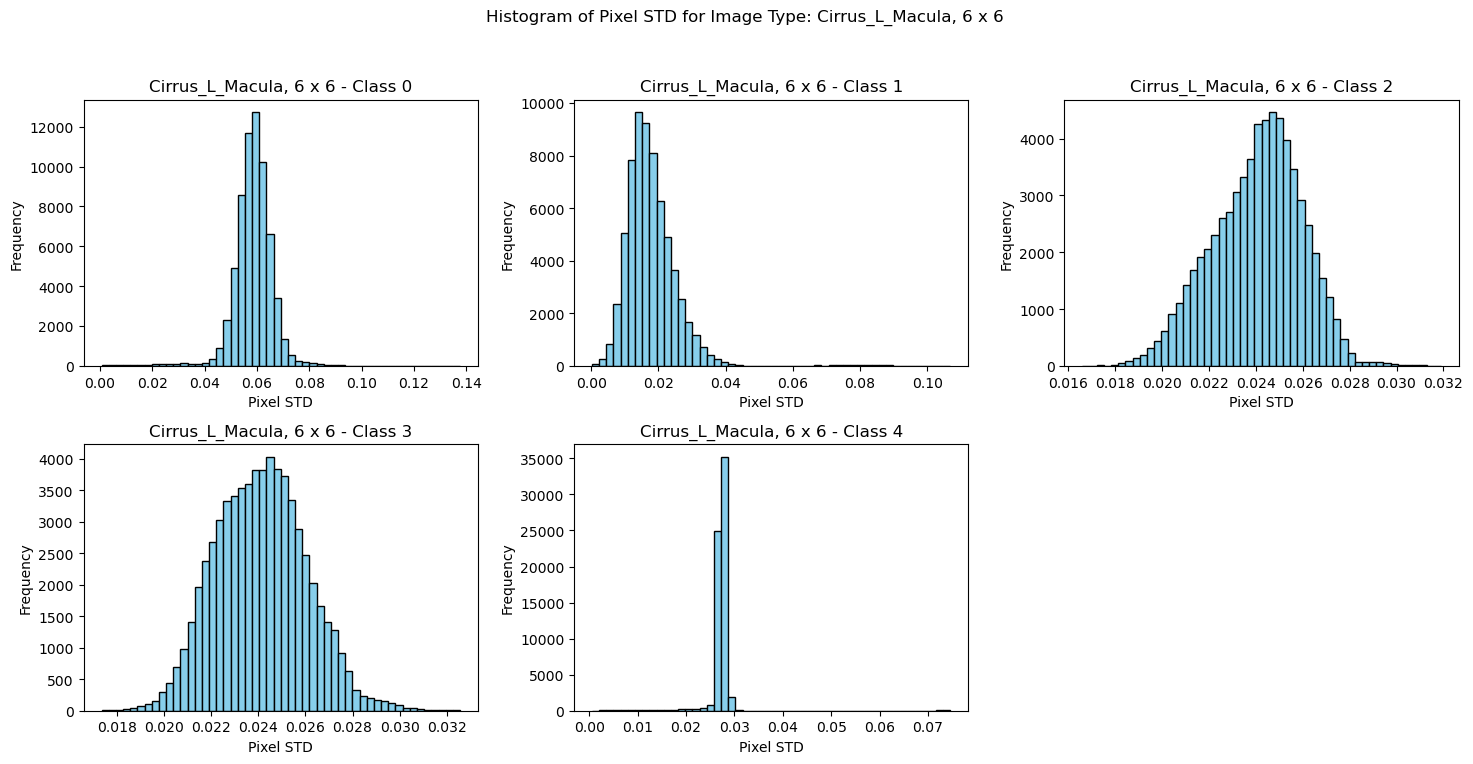

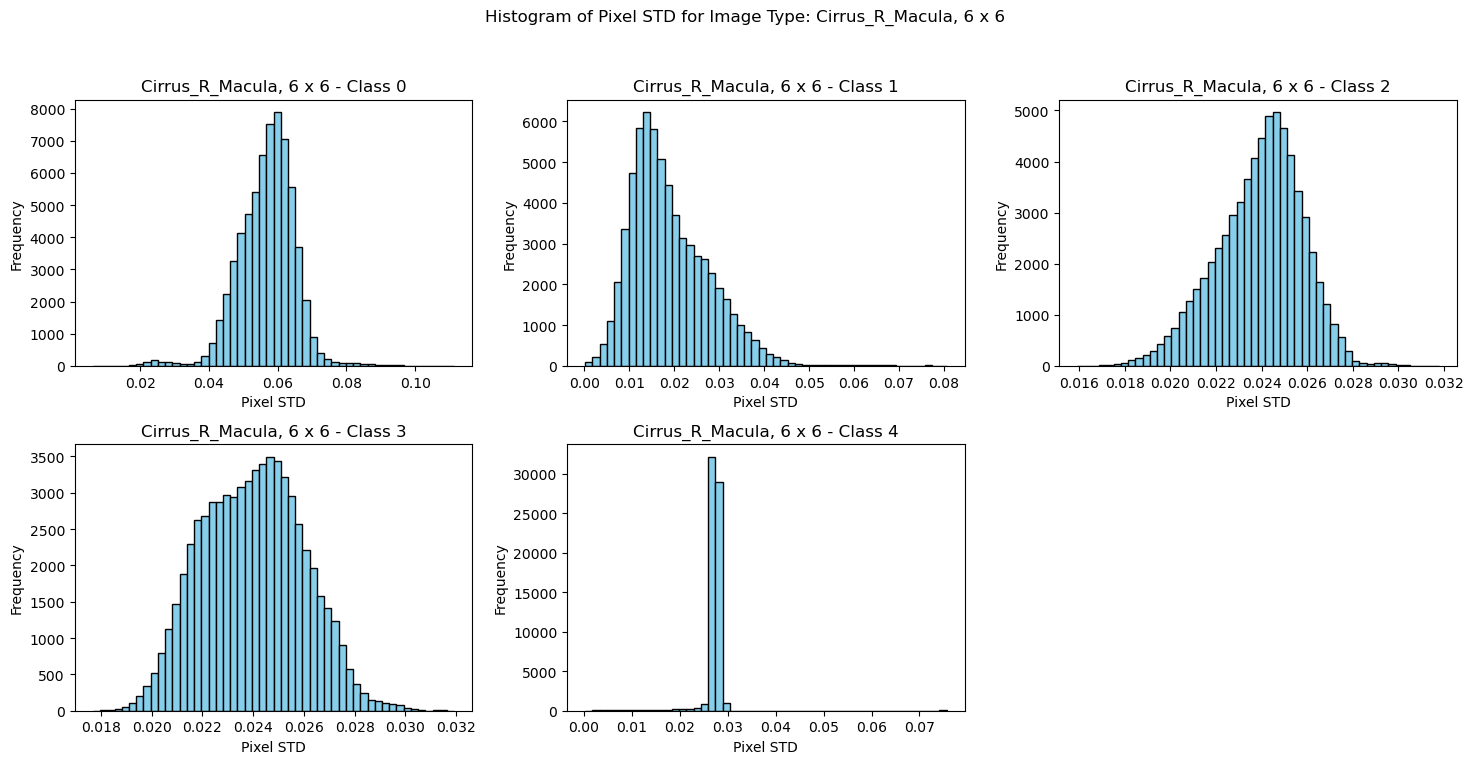

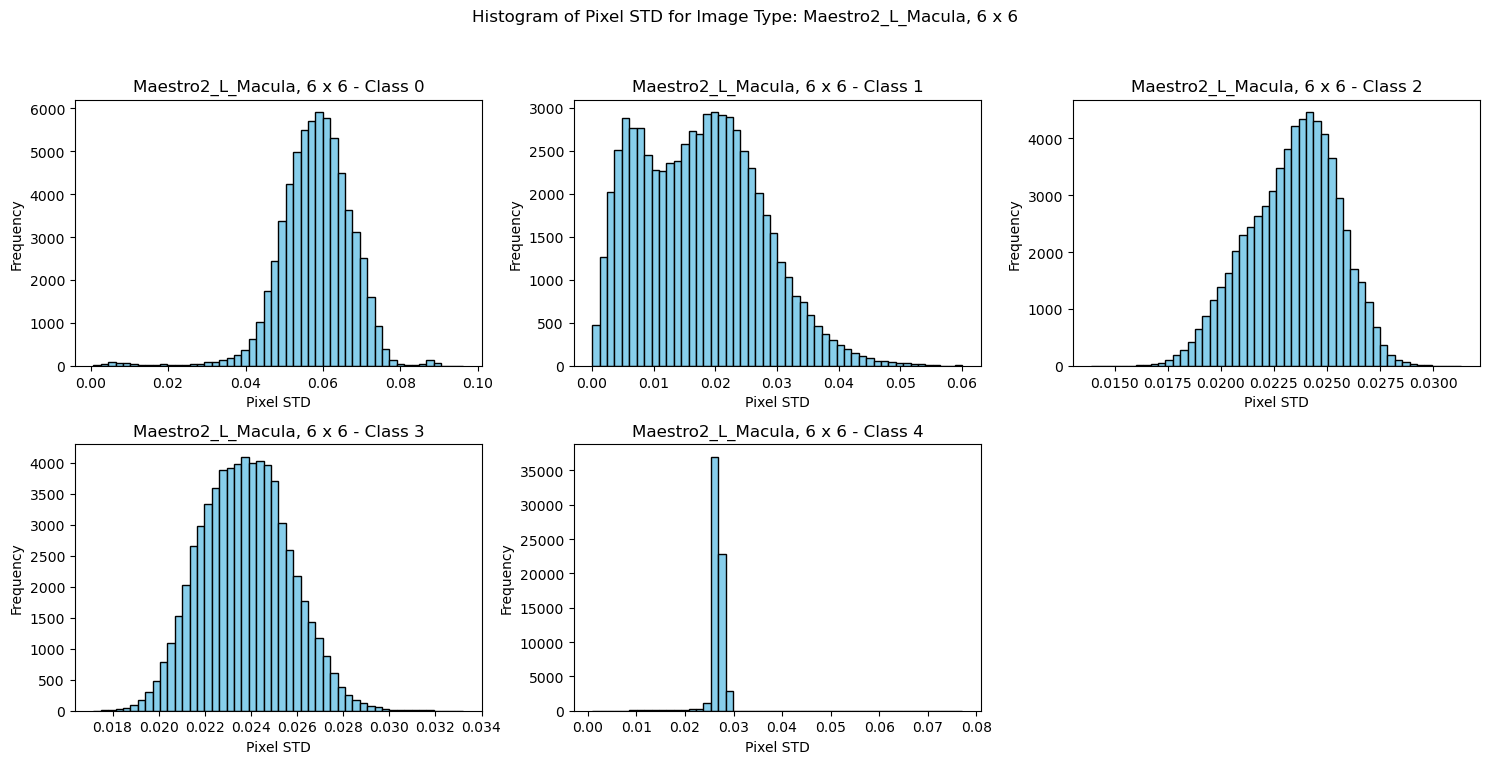

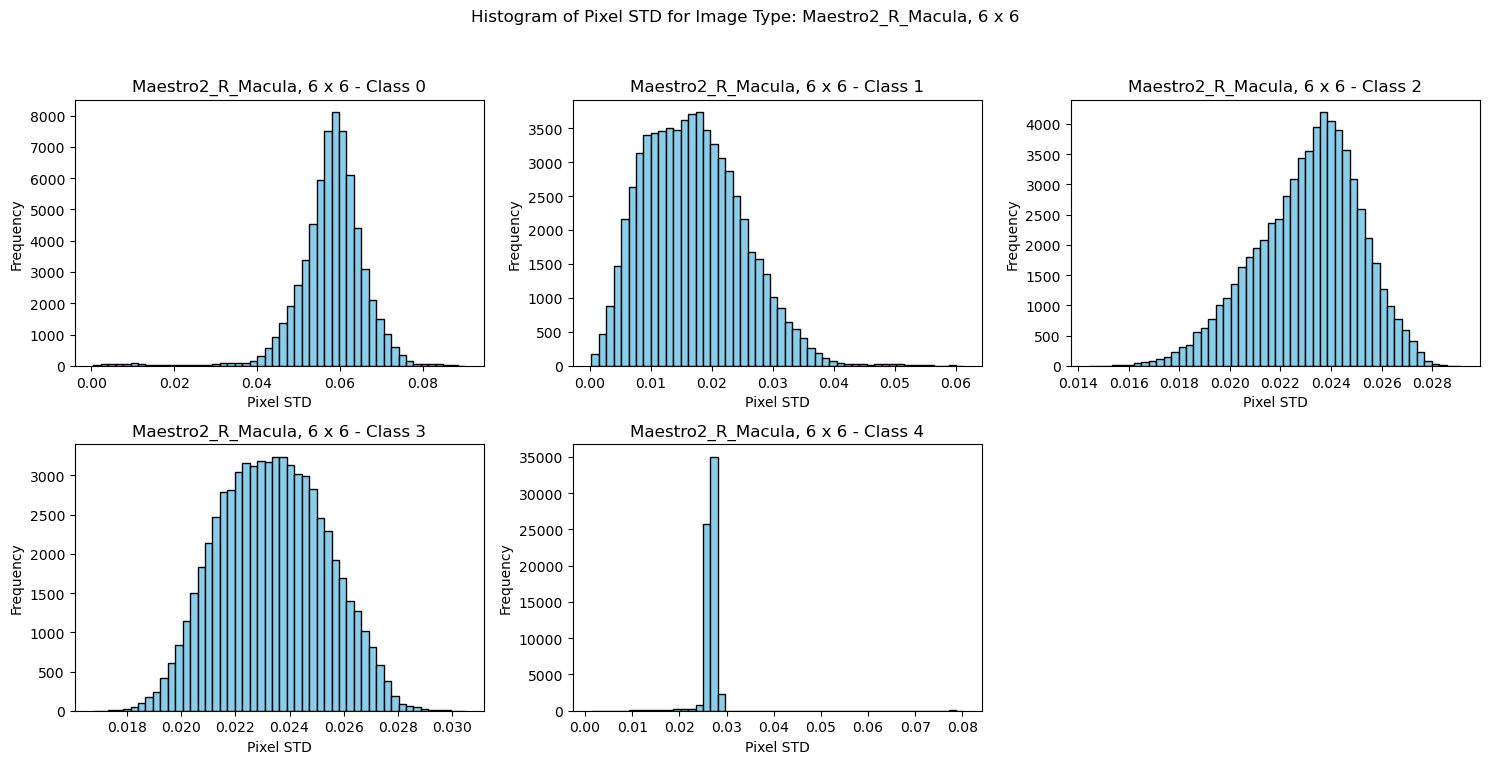

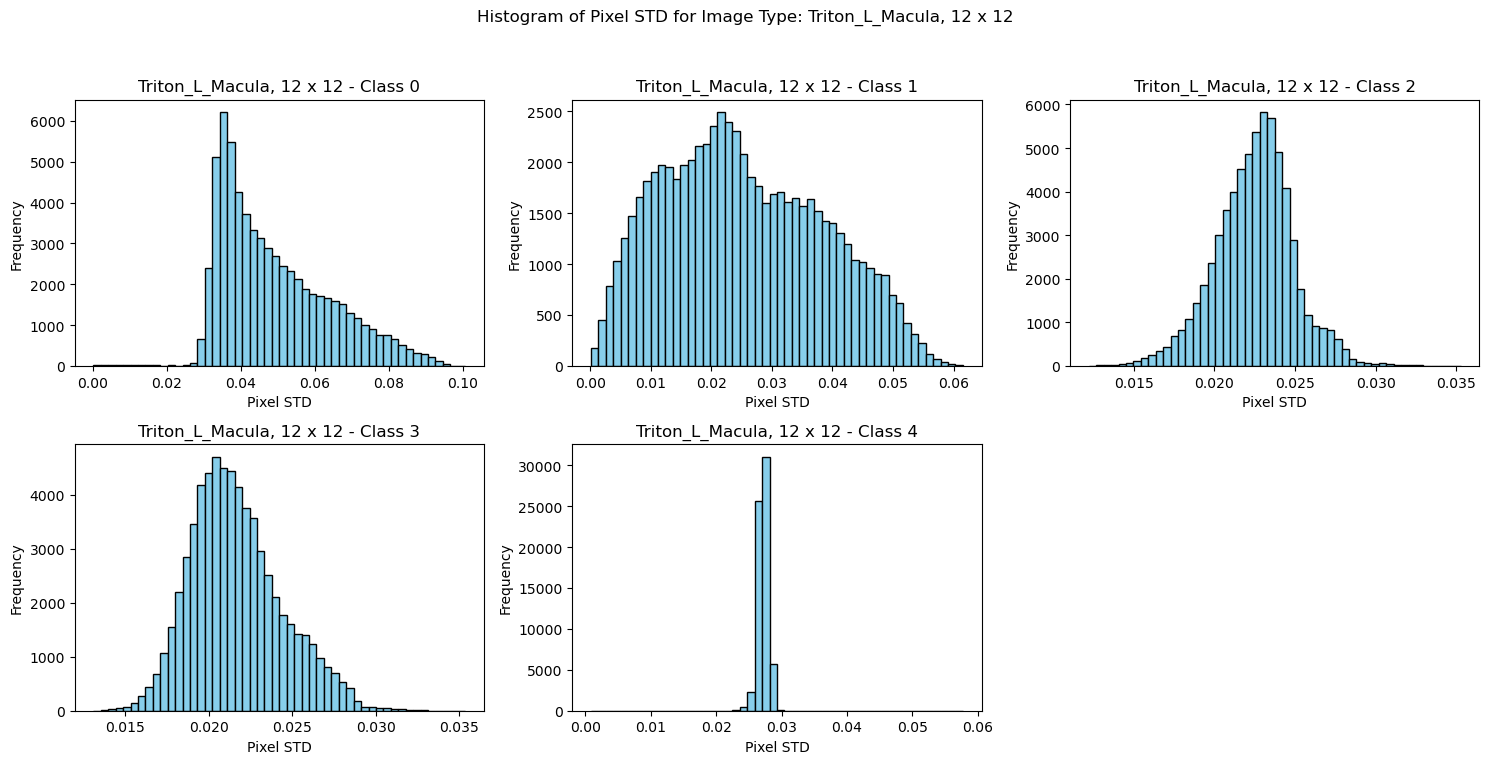

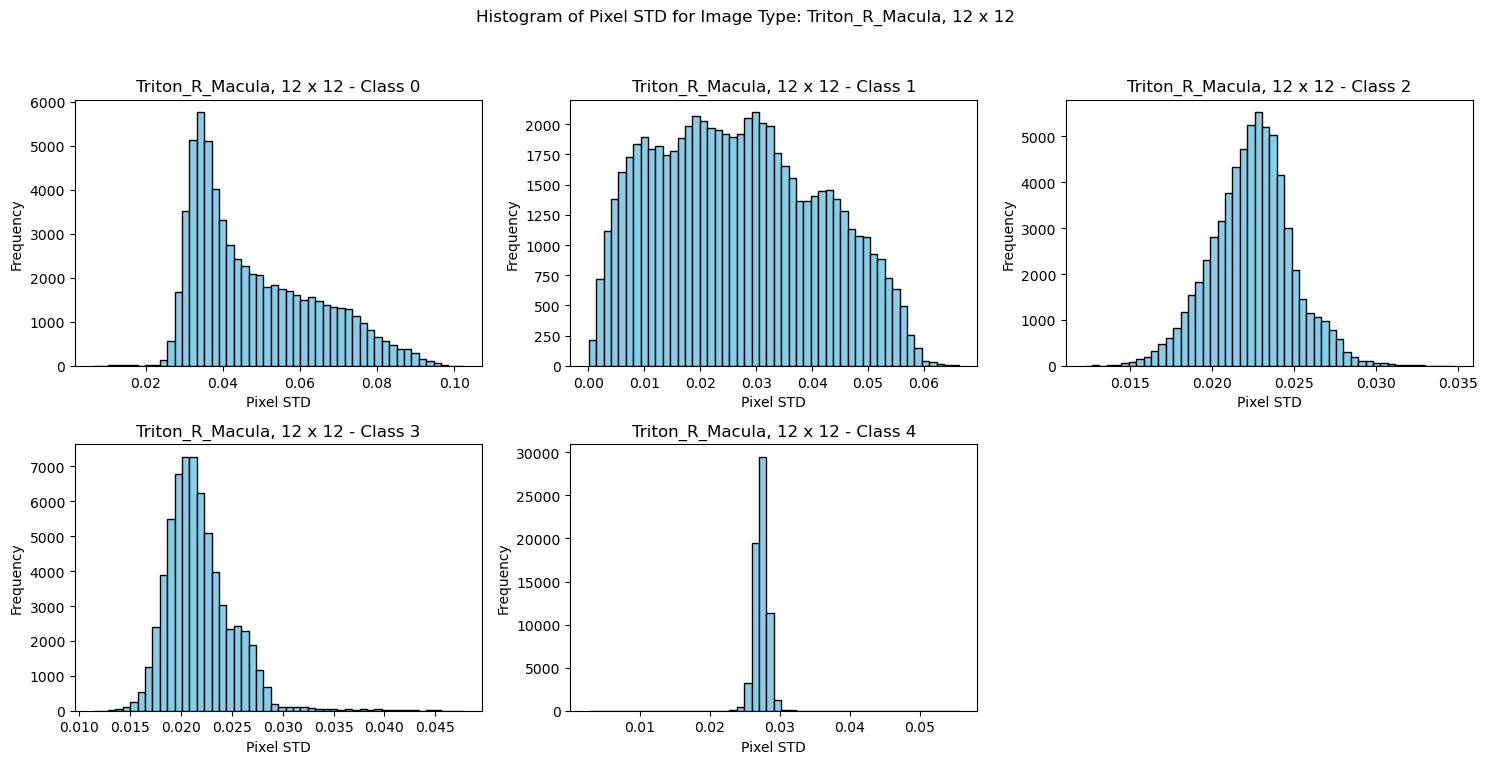

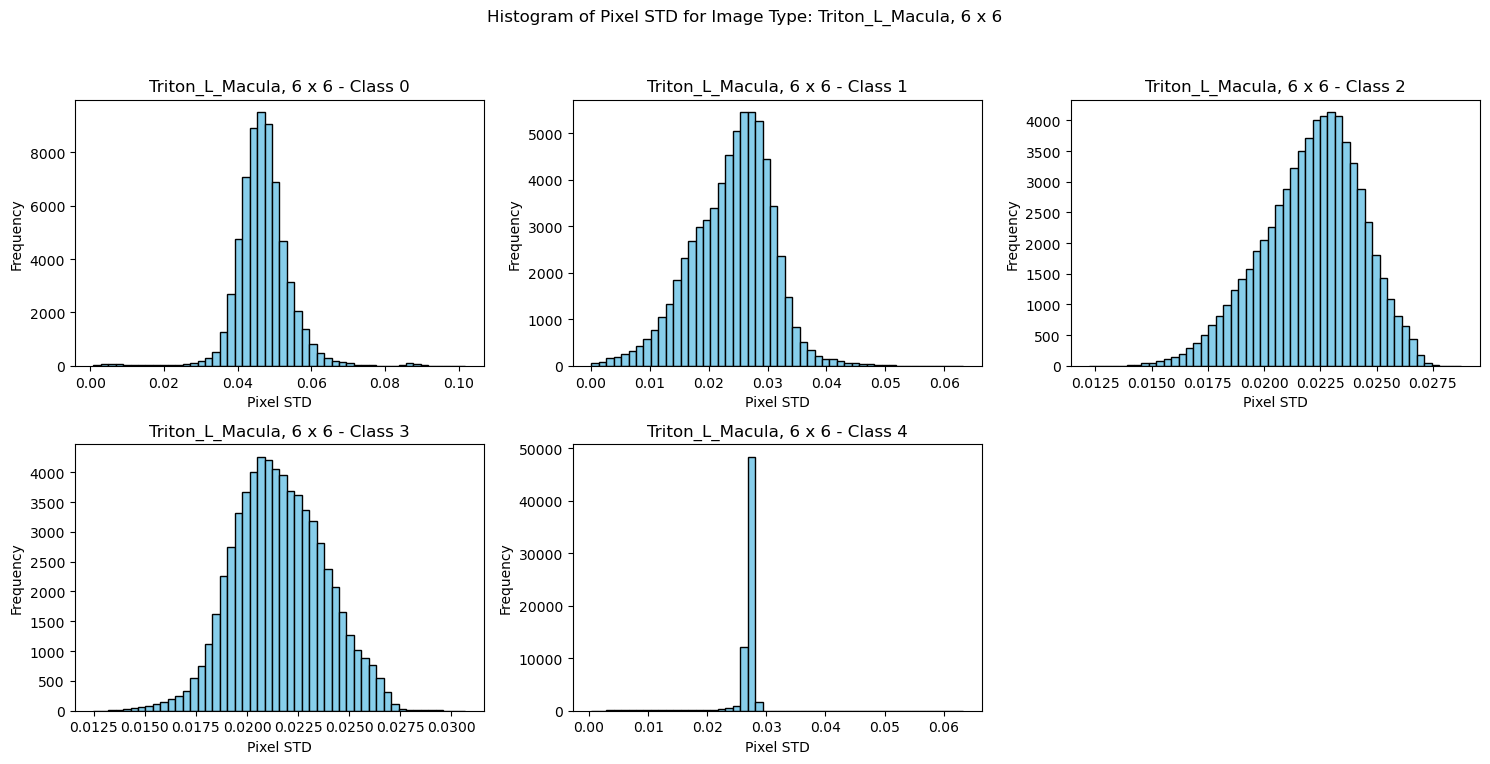

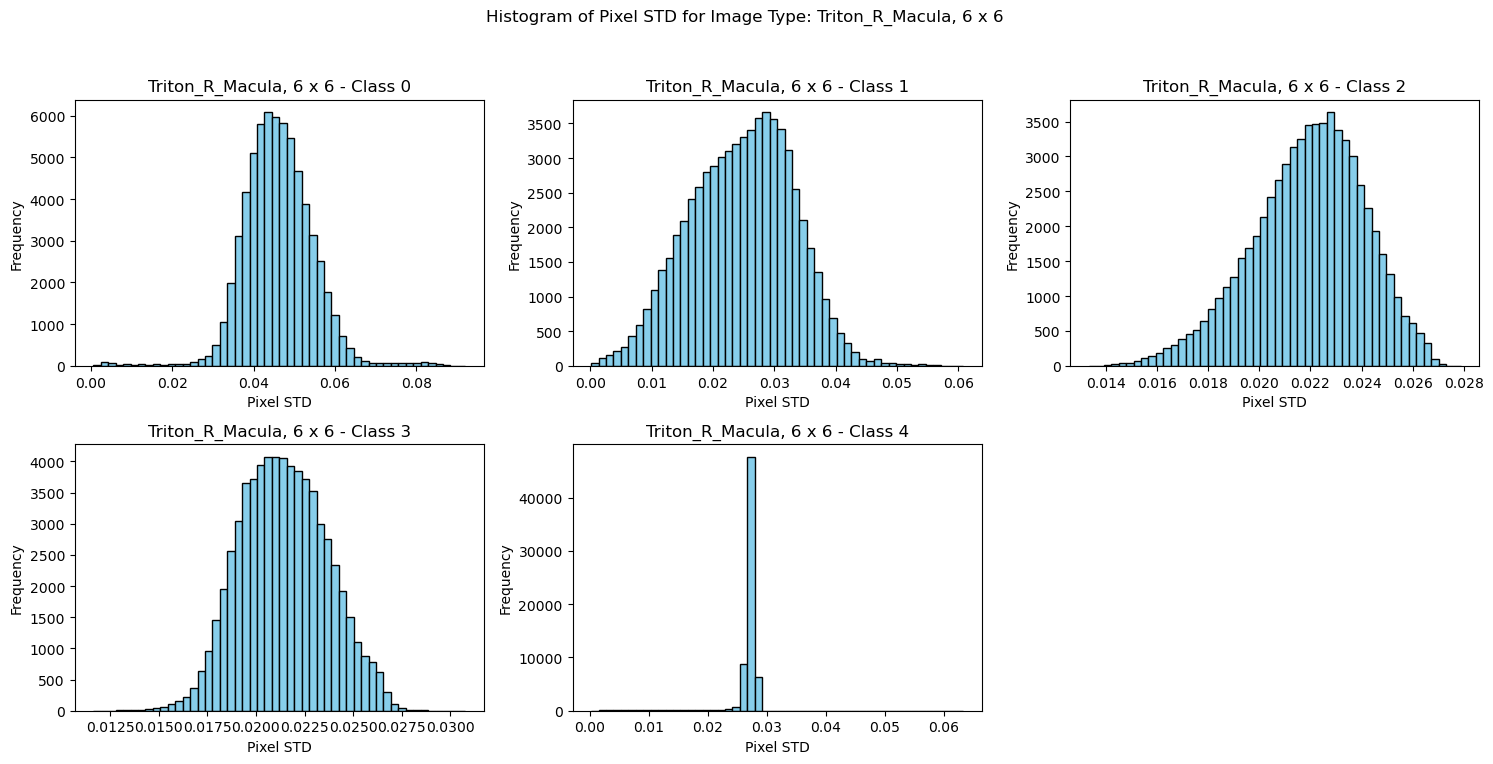

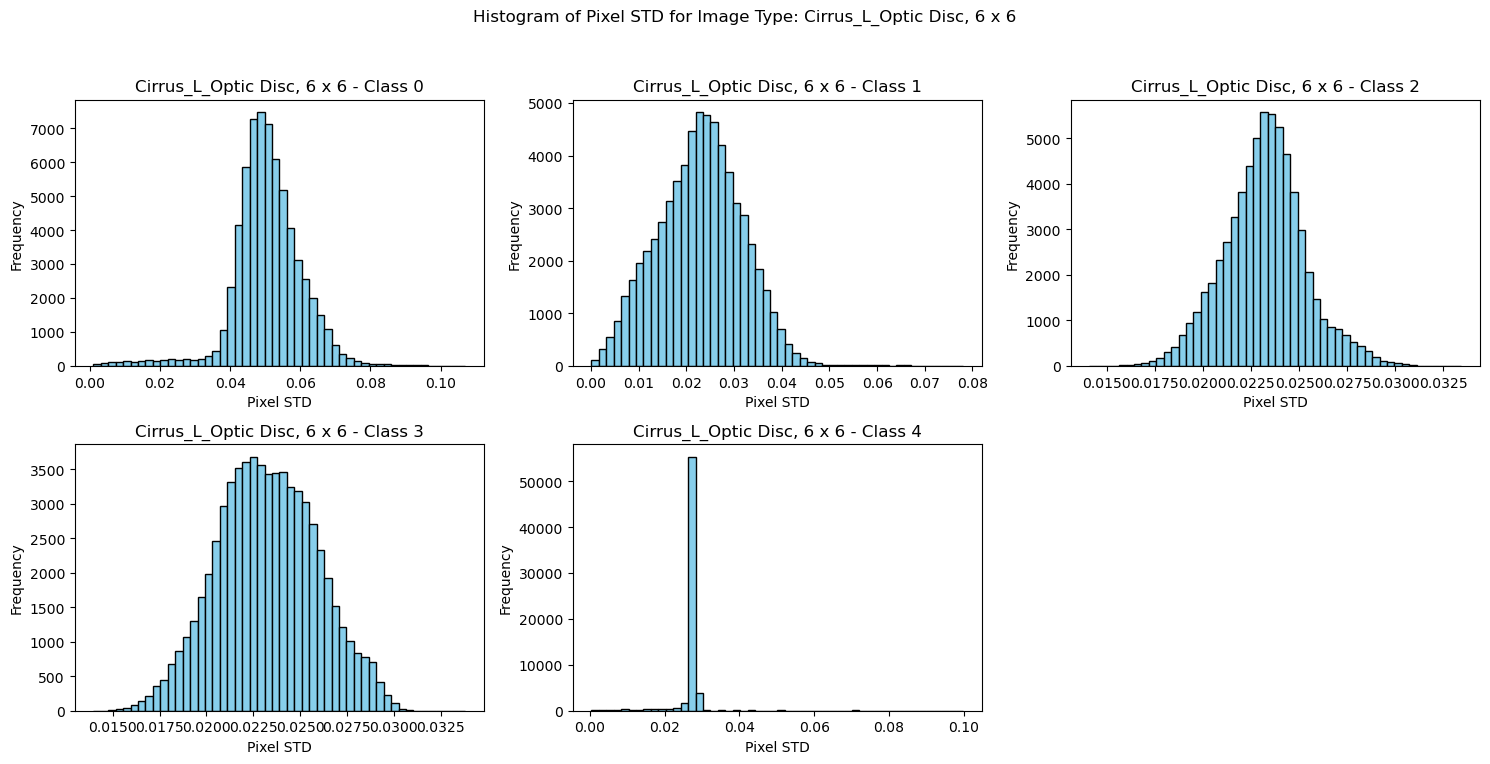

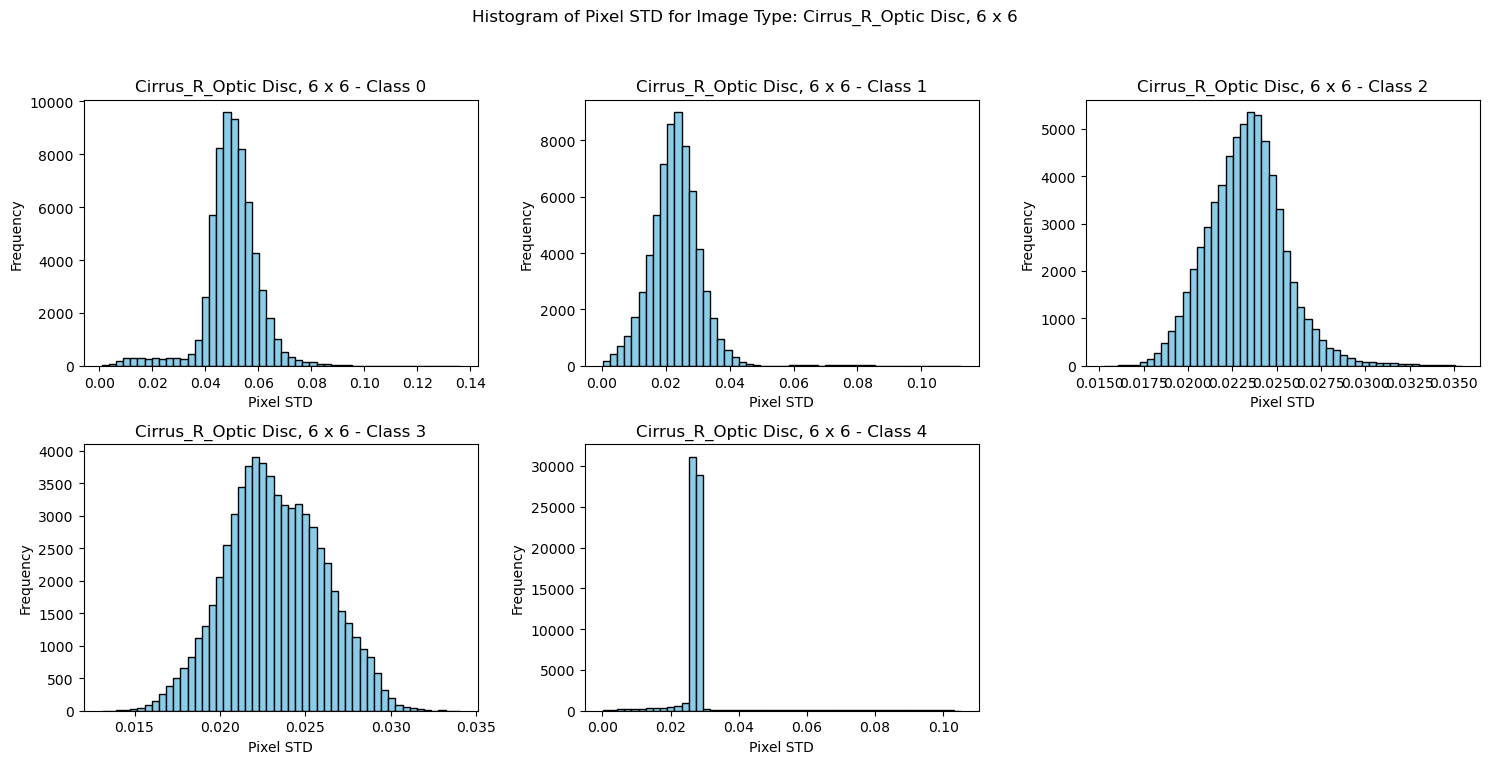

In [ ]:
import matplotlib.pyplot as plt

image_type_pixel_std = {}

for key in folder_avg_images[top_folders[0]].keys():
    avg_list = []
    valid = True
    for folder in top_folders:
        if key in folder_avg_images[folder]:
            avg_list.append(folder_avg_images[folder][key])
        else:
            print(f"Relative file {key} not found in folder {folder}. Skipping.")
            valid = False
            break
    if not valid:
        continue

    stacked = np.stack(avg_list, axis=0)

    image_type = key.split(os.sep)[0]
    if image_type not in image_type_pixel_std:
        image_type_pixel_std[image_type] = {c: [] for c in range(5)}

    for c in range(5):
        class_data = stacked[:, c, :, :]
        pixel_std = np.std(class_data, axis=0)
        image_type_pixel_std[image_type][c].append(pixel_std.flatten())

for image_type, class_dict in image_type_pixel_std.items():
    plt.figure(figsize=(15, 8))
    for c in range(5):
        if len(class_dict[c]) > 0:
            pixel_std_vals = np.concatenate(class_dict[c])
        else:
            pixel_std_vals = np.array([])
        plt.subplot(2, 3, c+1)
        plt.hist(pixel_std_vals, bins=50, color='skyblue', edgecolor='black')
        plt.xlabel("Pixel STD")
        plt.ylabel("Frequency")
        plt.title(f"{image_type} - Class {c}")
    plt.suptitle(f"Histogram of Pixel STD for Image Type: {image_type}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()